In [1]:
using Fretem, Potential, PyPlot, Printf, JLD

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{eq}(x)$ for simulation

In [3]:
V_eq = zeros(N)
F_eq = zeros(N)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq;

### Part 3: Langenvin dynamics simulations

In [4]:
# physical parameters
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
D = 4.845e9; # Diffusion coefficient, unit: angstrom^2 s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


In [6]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = xavg # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        F = 0
        ypos = ypos + D*dt*F + (dt*2*D)^(1/2) * randn()
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

### Part 4: Save trajectory or Read trajectory

In [8]:
# Save simulated trajectory to jld file
f_out = "../trajectory/zeroforce_tsim_10us_deltat_1ns.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D, "k_ref", 0)

In [12]:
# Read simulated trajectory from jld file
f_in = "../trajectory/zeroforce_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

### Part 5: Plot

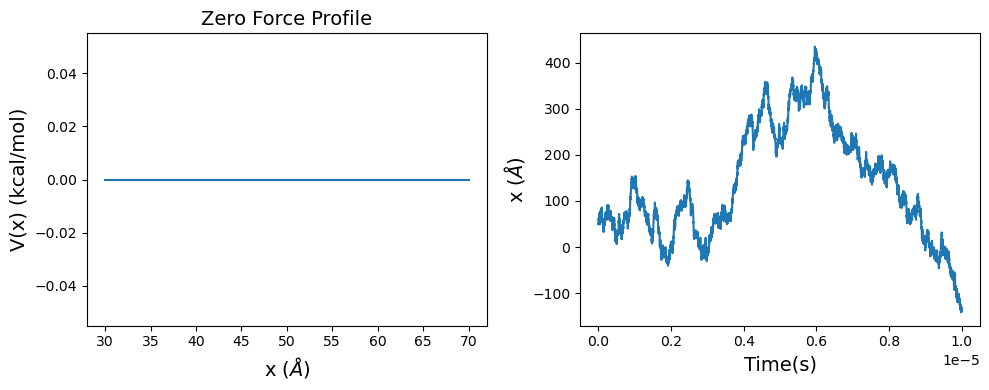

In [13]:
lbfz = 14
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

ax = axes[1]
ax.plot(xref, V_eq)
ax.set_xlabel("x (\$ \\AA \$)", fontsize=lbfz)
ax.set_ylabel("V(x) (kcal/mol)", fontsize=lbfz)
title = "Zero Force Profile"
ax.set_title(title, fontsize=lbfz)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_ylabel("x (\$ \\AA \$)", fontsize=lbfz)
ax.set_xlabel("Time(s)", fontsize=lbfz)
#ax.set_ylim(30,70)

plt.tight_layout()
plt.savefig("V_simu.png", dpi=150)
plt.show()